### Single-input Network - PyTorch

Predicts the action given a single observation (checks whether the Dataset is 'difficult' to learn)

### Imports

In [1]:
"""
Imports external and own libraries
"""

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

### Preprocess data

In [3]:
data = tmaze_random_reverse_data
n = 1

# change seq. length, recode actions, split dataset
dataset = preprocess.split_n_steps_between(data, n=n)
dataet, counter, translation_dict = preprocess.recode_actions(dataset, n)
train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset
oracle_train_data = preprocess.ObtainDualDataset(
    train_data, "observationsA", "observationsB", "actions"
)
oracle_test_data = preprocess.ObtainDualDataset(
    test_data, "observationsA", "observationsB", "actions"
)

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(
    oracle_train_data, batch_size=batch_size, shuffle=True
)
dataset_loader_test_data = DataLoader(
    oracle_test_data, batch_size=batch_size, shuffle=True
)

### Visualize a batch of data (size 64)

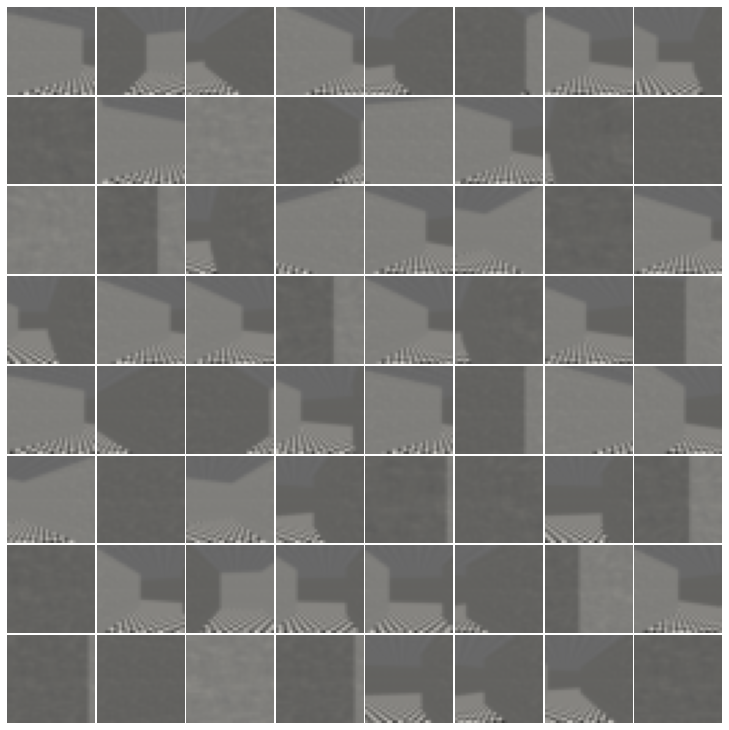

In [4]:
dataiter = iter(dataset_loader_train_data)
images, _, labels = dataiter.next()
plot.plot_64_observations(images)

### Initialize the model

In [5]:
forward = nets.Forward(4**n)
summary(forward, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 4]             340
Total params: 61,496
Trainable params: 61,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


### Train model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    forward.parameters(), lr=0.001
)  # , momentum=0.9) # for small one 0.01 works well

episodes = 500
forward, train_loss, test_loss, train_acc, test_acc = train.train_Feedforward(
    dataset_loader_train_data,
    dataset_loader_test_data,
    forward,
    criterion,
    optimizer,
    episodes,
)

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

inputs tensor([[[[0.3796, 0.3827, 0.3868,  ..., 0.4919, 0.4863, 0.4867],
          [0.3795, 0.3789, 0.3786,  ..., 0.4912, 0.4861, 0.4923],
          [0.3775, 0.3810, 0.3827,  ..., 0.4922, 0.4980, 0.5182],
          ...,
          [0.3986, 0.3992, 0.3980,  ..., 0.5050, 0.5143, 0.5260],
          [0.3862, 0.3880, 0.3879,  ..., 0.4988, 0.5104, 0.5162],
          [0.3854, 0.3908, 0.3895,  ..., 0.4998, 0.4982, 0.5112]],

         [[0.3773, 0.3796, 0.3838,  ..., 0.4886, 0.4833, 0.4838],
          [0.3771, 0.3765, 0.3762,  ..., 0.4883, 0.4834, 0.4897],
          [0.3753, 0.3787, 0.3804,  ..., 0.4890, 0.4952, 0.5155],
          ...,
          [0.3964, 0.3972, 0.3959,  ..., 0.5021, 0.5110, 0.5215],
          [0.3839, 0.3859, 0.3859,  ..., 0.4960, 0.5069, 0.5132],
          [0.3820, 0.3879, 0.3874,  ..., 0.4968, 0.4946, 0.5085]],

         [[0.3674, 0.3690, 0.3729,  ..., 0.4766, 0.4722, 0.4726],
          [0.3677, 0.3669, 0.3670,  ..., 0.4758, 0.4724, 0.4781],
          [0.3672, 0.3695, 0.3714, 

inputs tensor([[[[0.4125, 0.4117, 0.4007,  ..., 0.3892, 0.3838, 0.3827],
          [0.4073, 0.4123, 0.4038,  ..., 0.3863, 0.3809, 0.3870],
          [0.4158, 0.4118, 0.4031,  ..., 0.3912, 0.3918, 0.3961],
          ...,
          [0.5545, 0.4980, 0.4074,  ..., 0.3826, 0.3840, 0.3815],
          [0.5167, 0.6461, 0.6797,  ..., 0.3843, 0.3868, 0.3863],
          [0.4221, 0.3988, 0.4200,  ..., 0.3871, 0.3951, 0.3885]],

         [[0.4125, 0.4117, 0.4008,  ..., 0.3871, 0.3815, 0.3798],
          [0.4073, 0.4122, 0.4040,  ..., 0.3841, 0.3786, 0.3847],
          [0.4157, 0.4116, 0.4032,  ..., 0.3887, 0.3895, 0.3938],
          ...,
          [0.5485, 0.4931, 0.4032,  ..., 0.3802, 0.3814, 0.3790],
          [0.5107, 0.6388, 0.6720,  ..., 0.3821, 0.3845, 0.3837],
          [0.4177, 0.3943, 0.4152,  ..., 0.3849, 0.3929, 0.3863]],

         [[0.4134, 0.4129, 0.4019,  ..., 0.3767, 0.3717, 0.3701],
          [0.4089, 0.4139, 0.4054,  ..., 0.3743, 0.3694, 0.3750],
          [0.4178, 0.4138, 0.4047, 

inputs tensor([[[[0.4058, 0.4093, 0.4179,  ..., 0.4137, 0.4122, 0.4117],
          [0.4065, 0.4018, 0.4028,  ..., 0.4116, 0.4107, 0.4158],
          [0.4119, 0.4101, 0.4097,  ..., 0.4119, 0.4134, 0.4107],
          ...,
          [0.5067, 0.5045, 0.5029,  ..., 0.5897, 0.4034, 0.6321],
          [0.5112, 0.4425, 0.4319,  ..., 0.6850, 0.4786, 0.5040],
          [0.6113, 0.2688, 0.3203,  ..., 0.6676, 0.4601, 0.2953]],

         [[0.4058, 0.4094, 0.4180,  ..., 0.4136, 0.4121, 0.4116],
          [0.4066, 0.4019, 0.4029,  ..., 0.4115, 0.4107, 0.4156],
          [0.4118, 0.4101, 0.4096,  ..., 0.4118, 0.4133, 0.4107],
          ...,
          [0.5032, 0.5013, 0.4999,  ..., 0.5836, 0.3991, 0.6250],
          [0.5075, 0.4394, 0.4287,  ..., 0.6772, 0.4734, 0.4983],
          [0.6052, 0.2654, 0.3165,  ..., 0.6607, 0.4550, 0.2915]],

         [[0.4069, 0.4104, 0.4187,  ..., 0.4148, 0.4133, 0.4135],
          [0.4077, 0.4033, 0.4038,  ..., 0.4131, 0.4127, 0.4180],
          [0.4127, 0.4116, 0.4119, 

inputs tensor([[[[0.3859, 0.3828, 0.3824,  ..., 0.4171, 0.4143, 0.4006],
          [0.3933, 0.3858, 0.3790,  ..., 0.4185, 0.4181, 0.4125],
          [0.3997, 0.3937, 0.3853,  ..., 0.4062, 0.4086, 0.4161],
          ...,
          [0.3898, 0.3927, 0.3940,  ..., 0.3931, 0.3924, 0.3957],
          [0.4004, 0.3979, 0.3966,  ..., 0.3895, 0.3978, 0.5121],
          [0.3930, 0.3944, 0.3951,  ..., 0.4284, 0.3042, 0.5312]],

         [[0.3836, 0.3809, 0.3811,  ..., 0.4170, 0.4143, 0.4008],
          [0.3911, 0.3838, 0.3775,  ..., 0.4185, 0.4181, 0.4125],
          [0.3973, 0.3911, 0.3831,  ..., 0.4059, 0.4085, 0.4160],
          ...,
          [0.3875, 0.3903, 0.3916,  ..., 0.3906, 0.3900, 0.3933],
          [0.3981, 0.3955, 0.3940,  ..., 0.3869, 0.3951, 0.5078],
          [0.3904, 0.3913, 0.3920,  ..., 0.4249, 0.3008, 0.5246]],

         [[0.3742, 0.3728, 0.3738,  ..., 0.4187, 0.4154, 0.4014],
          [0.3807, 0.3748, 0.3698,  ..., 0.4195, 0.4188, 0.4135],
          [0.3867, 0.3802, 0.3734, 

inputs tensor([[[[0.3907, 0.3914, 0.3891,  ..., 0.4933, 0.4831, 0.4923],
          [0.3840, 0.3820, 0.3835,  ..., 0.4886, 0.4908, 0.5011],
          [0.3851, 0.3834, 0.3865,  ..., 0.4921, 0.4924, 0.4883],
          ...,
          [0.3866, 0.3825, 0.3866,  ..., 0.5012, 0.5014, 0.4930],
          [0.3838, 0.3830, 0.3859,  ..., 0.4953, 0.4920, 0.4865],
          [0.3852, 0.3779, 0.3822,  ..., 0.4988, 0.4994, 0.4908]],

         [[0.3887, 0.3886, 0.3867,  ..., 0.4907, 0.4806, 0.4891],
          [0.3816, 0.3795, 0.3813,  ..., 0.4856, 0.4880, 0.4979],
          [0.3823, 0.3810, 0.3842,  ..., 0.4892, 0.4896, 0.4852],
          ...,
          [0.3844, 0.3803, 0.3842,  ..., 0.4981, 0.4987, 0.4900],
          [0.3812, 0.3806, 0.3836,  ..., 0.4925, 0.4892, 0.4836],
          [0.3828, 0.3754, 0.3800,  ..., 0.4960, 0.4964, 0.4875]],

         [[0.3778, 0.3784, 0.3774,  ..., 0.4795, 0.4717, 0.4779],
          [0.3720, 0.3703, 0.3722,  ..., 0.4743, 0.4774, 0.4859],
          [0.3721, 0.3715, 0.3742, 

inputs tensor([[[[0.4189, 0.4105, 0.4043,  ..., 0.4148, 0.4146, 0.4181],
          [0.4079, 0.4055, 0.4018,  ..., 0.4141, 0.4249, 0.4417],
          [0.4054, 0.4038, 0.4082,  ..., 0.4663, 0.4847, 0.4879],
          ...,
          [0.6049, 0.4488, 0.5572,  ..., 0.4985, 0.4995, 0.5099],
          [0.4712, 0.6025, 0.6330,  ..., 0.4996, 0.4988, 0.5004],
          [0.3476, 0.5103, 0.3093,  ..., 0.4997, 0.4996, 0.5036]],

         [[0.4189, 0.4105, 0.4042,  ..., 0.4147, 0.4146, 0.4180],
          [0.4078, 0.4054, 0.4019,  ..., 0.4139, 0.4244, 0.4403],
          [0.4053, 0.4040, 0.4083,  ..., 0.4644, 0.4819, 0.4847],
          ...,
          [0.5973, 0.4437, 0.5508,  ..., 0.4953, 0.4964, 0.5066],
          [0.4660, 0.5957, 0.6258,  ..., 0.4960, 0.4958, 0.4975],
          [0.3439, 0.5058, 0.3060,  ..., 0.4965, 0.4966, 0.5007]],

         [[0.4206, 0.4119, 0.4056,  ..., 0.4158, 0.4156, 0.4186],
          [0.4092, 0.4068, 0.4035,  ..., 0.4139, 0.4230, 0.4366],
          [0.4069, 0.4050, 0.4093, 

inputs tensor([[[[0.4143, 0.4063, 0.4103,  ..., 0.3992, 0.4068, 0.4046],
          [0.4142, 0.4155, 0.4190,  ..., 0.4052, 0.4067, 0.4040],
          [0.4061, 0.4045, 0.4073,  ..., 0.4130, 0.4114, 0.4097],
          ...,
          [0.4906, 0.4748, 0.5649,  ..., 0.5842, 0.5102, 0.4283],
          [0.3209, 0.3555, 0.6055,  ..., 0.4995, 0.6724, 0.3980],
          [0.6160, 0.5057, 0.2691,  ..., 0.4652, 0.6752, 0.3986]],

         [[0.4144, 0.4062, 0.4102,  ..., 0.3993, 0.4068, 0.4046],
          [0.4141, 0.4155, 0.4188,  ..., 0.4052, 0.4067, 0.4041],
          [0.4062, 0.4045, 0.4072,  ..., 0.4129, 0.4113, 0.4097],
          ...,
          [0.4872, 0.4716, 0.5607,  ..., 0.5776, 0.5045, 0.4234],
          [0.3185, 0.3519, 0.5988,  ..., 0.4939, 0.6643, 0.3936],
          [0.6100, 0.5011, 0.2660,  ..., 0.4612, 0.6686, 0.3939]],

         [[0.4172, 0.4078, 0.4129,  ..., 0.4004, 0.4087, 0.4061],
          [0.4163, 0.4168, 0.4209,  ..., 0.4070, 0.4083, 0.4056],
          [0.4071, 0.4064, 0.4089, 

Epoch: 1, Train Loss: 1.388, Train Acc: 25.44 %,  Test Loss: 1.395, Test Acc: 25.06 %,
inputs tensor([[[[0.3844, 0.3888, 0.3951,  ..., 0.3820, 0.3823, 0.3896],
          [0.3957, 0.3918, 0.3901,  ..., 0.3862, 0.3921, 0.3921],
          [0.4038, 0.3908, 0.3864,  ..., 0.3974, 0.4009, 0.4022],
          ...,
          [0.3846, 0.3895, 0.3856,  ..., 0.4067, 0.4012, 0.3965],
          [0.3937, 0.3899, 0.3890,  ..., 0.4010, 0.3992, 0.3923],
          [0.3975, 0.3888, 0.3878,  ..., 0.3940, 0.3977, 0.3924]],

         [[0.3819, 0.3863, 0.3923,  ..., 0.3794, 0.3800, 0.3874],
          [0.3930, 0.3895, 0.3878,  ..., 0.3840, 0.3896, 0.3891],
          [0.4009, 0.3886, 0.3839,  ..., 0.3953, 0.3989, 0.3998],
          ...,
          [0.3822, 0.3868, 0.3831,  ..., 0.4040, 0.3987, 0.3931],
          [0.3909, 0.3875, 0.3868,  ..., 0.3988, 0.3970, 0.3900],
          [0.3948, 0.3865, 0.3852,  ..., 0.3918, 0.3954, 0.3902]],

         [[0.3721, 0.3764, 0.3813,  ..., 0.3701, 0.3712, 0.3784],
          [0.3

inputs tensor([[[[0.3845, 0.3784, 0.3726,  ..., 0.5188, 0.5176, 0.5083],
          [0.3998, 0.3878, 0.3800,  ..., 0.5067, 0.5101, 0.5135],
          [0.4077, 0.4006, 0.3969,  ..., 0.5133, 0.5113, 0.5098],
          ...,
          [0.3835, 0.3787, 0.3785,  ..., 0.4950, 0.4784, 0.4779],
          [0.3821, 0.3723, 0.3712,  ..., 0.4901, 0.4862, 0.4904],
          [0.3741, 0.3698, 0.3721,  ..., 0.4877, 0.4902, 0.4976]],

         [[0.3826, 0.3763, 0.3705,  ..., 0.5153, 0.5138, 0.5061],
          [0.3983, 0.3857, 0.3779,  ..., 0.5033, 0.5070, 0.5097],
          [0.4059, 0.3981, 0.3947,  ..., 0.5105, 0.5085, 0.5064],
          ...,
          [0.3805, 0.3762, 0.3761,  ..., 0.4918, 0.4771, 0.4770],
          [0.3791, 0.3699, 0.3688,  ..., 0.4873, 0.4848, 0.4887],
          [0.3719, 0.3681, 0.3699,  ..., 0.4851, 0.4875, 0.4952]],

         [[0.3721, 0.3674, 0.3616,  ..., 0.5006, 0.4988, 0.4921],
          [0.3854, 0.3763, 0.3689,  ..., 0.4887, 0.4923, 0.4933],
          [0.3940, 0.3871, 0.3847, 

inputs tensor([[[[0.4208, 0.4235, 0.4155,  ..., 0.4252, 0.4430, 0.4579],
          [0.4130, 0.4095, 0.4051,  ..., 0.4883, 0.5001, 0.4910],
          [0.4031, 0.4041, 0.4022,  ..., 0.4909, 0.4954, 0.4905],
          ...,
          [0.6339, 0.5520, 0.4015,  ..., 0.5089, 0.5165, 0.5084],
          [0.6995, 0.4594, 0.5364,  ..., 0.5002, 0.4986, 0.5086],
          [0.4871, 0.2935, 0.5508,  ..., 0.4998, 0.4979, 0.5009]],

         [[0.4209, 0.4234, 0.4154,  ..., 0.4245, 0.4416, 0.4558],
          [0.4129, 0.4095, 0.4050,  ..., 0.4856, 0.4967, 0.4876],
          [0.4031, 0.4042, 0.4021,  ..., 0.4881, 0.4922, 0.4868],
          ...,
          [0.6269, 0.5462, 0.3968,  ..., 0.5053, 0.5129, 0.5051],
          [0.6918, 0.4551, 0.5299,  ..., 0.4971, 0.4956, 0.5054],
          [0.4809, 0.2897, 0.5448,  ..., 0.4964, 0.4949, 0.4980]],

         [[0.4217, 0.4254, 0.4169,  ..., 0.4227, 0.4382, 0.4490],
          [0.4136, 0.4111, 0.4071,  ..., 0.4743, 0.4838, 0.4757],
          [0.4046, 0.4059, 0.4035, 

inputs tensor([[[[0.3911, 0.3898, 0.3928,  ..., 0.4072, 0.4178, 0.4258],
          [0.3893, 0.3988, 0.3977,  ..., 0.4009, 0.4125, 0.4199],
          [0.3913, 0.3933, 0.3939,  ..., 0.4018, 0.4118, 0.4215],
          ...,
          [0.3844, 0.3871, 0.3815,  ..., 0.4978, 0.4348, 0.4853],
          [0.3902, 0.3966, 0.3892,  ..., 0.5690, 0.6589, 0.5690],
          [0.3917, 0.3906, 0.3837,  ..., 0.3763, 0.3041, 0.4557]],

         [[0.3886, 0.3870, 0.3903,  ..., 0.4072, 0.4177, 0.4258],
          [0.3865, 0.3958, 0.3950,  ..., 0.4009, 0.4124, 0.4199],
          [0.3890, 0.3910, 0.3914,  ..., 0.4018, 0.4117, 0.4215],
          ...,
          [0.3817, 0.3849, 0.3794,  ..., 0.4920, 0.4299, 0.4803],
          [0.3882, 0.3939, 0.3868,  ..., 0.5626, 0.6515, 0.5631],
          [0.3896, 0.3881, 0.3813,  ..., 0.3722, 0.3004, 0.4507]],

         [[0.3785, 0.3766, 0.3800,  ..., 0.4082, 0.4194, 0.4273],
          [0.3761, 0.3843, 0.3837,  ..., 0.4023, 0.4136, 0.4206],
          [0.3790, 0.3806, 0.3812, 

inputs tensor([[[[0.3922, 0.4037, 0.3897,  ..., 0.4111, 0.4133, 0.4244],
          [0.3910, 0.3958, 0.3934,  ..., 0.4545, 0.4641, 0.4654],
          [0.3881, 0.3863, 0.3993,  ..., 0.5001, 0.5001, 0.4902],
          ...,
          [0.3868, 0.3929, 0.3840,  ..., 0.4979, 0.5030, 0.5068],
          [0.3873, 0.3879, 0.3829,  ..., 0.4962, 0.5065, 0.5035],
          [0.3824, 0.3830, 0.3841,  ..., 0.5049, 0.5061, 0.4979]],

         [[0.3894, 0.4008, 0.3871,  ..., 0.4110, 0.4131, 0.4241],
          [0.3885, 0.3932, 0.3908,  ..., 0.4531, 0.4623, 0.4634],
          [0.3855, 0.3838, 0.3965,  ..., 0.4972, 0.4970, 0.4873],
          ...,
          [0.3846, 0.3901, 0.3816,  ..., 0.4949, 0.4995, 0.5036],
          [0.3852, 0.3855, 0.3803,  ..., 0.4931, 0.5033, 0.5005],
          [0.3803, 0.3808, 0.3817,  ..., 0.5020, 0.5034, 0.4949]],

         [[0.3784, 0.3894, 0.3770,  ..., 0.4127, 0.4142, 0.4254],
          [0.3776, 0.3823, 0.3802,  ..., 0.4465, 0.4546, 0.4561],
          [0.3749, 0.3737, 0.3852, 

inputs tensor([[[[0.3960, 0.4136, 0.4180,  ..., 0.4077, 0.4148, 0.4104],
          [0.3945, 0.4066, 0.4155,  ..., 0.4164, 0.4066, 0.4055],
          [0.3889, 0.4004, 0.4232,  ..., 0.4106, 0.4073, 0.4112],
          ...,
          [0.3903, 0.4132, 0.4906,  ..., 0.5724, 0.6885, 0.5377],
          [0.3930, 0.4128, 0.4908,  ..., 0.5621, 0.6485, 0.3915],
          [0.3918, 0.4065, 0.4485,  ..., 0.5293, 0.7428, 0.4377]],

         [[0.3958, 0.4136, 0.4180,  ..., 0.4075, 0.4146, 0.4103],
          [0.3931, 0.4063, 0.4154,  ..., 0.4162, 0.4065, 0.4056],
          [0.3866, 0.3989, 0.4224,  ..., 0.4106, 0.4074, 0.4112],
          ...,
          [0.3878, 0.4107, 0.4877,  ..., 0.5665, 0.6821, 0.5335],
          [0.3905, 0.4101, 0.4879,  ..., 0.5554, 0.6420, 0.3871],
          [0.3895, 0.4040, 0.4459,  ..., 0.5231, 0.7349, 0.4329]],

         [[0.3957, 0.4143, 0.4184,  ..., 0.4098, 0.4161, 0.4112],
          [0.3871, 0.4061, 0.4164,  ..., 0.4183, 0.4079, 0.4066],
          [0.3767, 0.3939, 0.4210, 

inputs tensor([[[[0.3930, 0.3905, 0.3842,  ..., 0.3847, 0.3907, 0.3958],
          [0.3991, 0.3937, 0.3894,  ..., 0.3880, 0.3914, 0.3915],
          [0.3920, 0.3941, 0.3976,  ..., 0.3872, 0.3947, 0.3909],
          ...,
          [0.3808, 0.3839, 0.3815,  ..., 0.3886, 0.3873, 0.3791],
          [0.3898, 0.3898, 0.3872,  ..., 0.3870, 0.3892, 0.3783],
          [0.4016, 0.3993, 0.3970,  ..., 0.3928, 0.3932, 0.3852]],

         [[0.3907, 0.3879, 0.3820,  ..., 0.3824, 0.3884, 0.3934],
          [0.3968, 0.3913, 0.3873,  ..., 0.3858, 0.3891, 0.3888],
          [0.3894, 0.3916, 0.3954,  ..., 0.3849, 0.3924, 0.3882],
          ...,
          [0.3784, 0.3815, 0.3791,  ..., 0.3862, 0.3850, 0.3767],
          [0.3877, 0.3874, 0.3849,  ..., 0.3845, 0.3869, 0.3757],
          [0.3995, 0.3971, 0.3946,  ..., 0.3905, 0.3910, 0.3827]],

         [[0.3803, 0.3779, 0.3728,  ..., 0.3736, 0.3799, 0.3840],
          [0.3861, 0.3806, 0.3771,  ..., 0.3763, 0.3793, 0.3783],
          [0.3788, 0.3812, 0.3850, 

inputs tensor([[[[0.4900, 0.4877, 0.4889,  ..., 0.5063, 0.4982, 0.4952],
          [0.4956, 0.4978, 0.4900,  ..., 0.5066, 0.5059, 0.4961],
          [0.5061, 0.5032, 0.4977,  ..., 0.4967, 0.5061, 0.5059],
          ...,
          [0.4901, 0.4878, 0.4925,  ..., 0.5035, 0.4972, 0.5022],
          [0.4875, 0.4924, 0.5074,  ..., 0.5017, 0.5009, 0.5063],
          [0.5015, 0.5034, 0.5176,  ..., 0.5003, 0.5029, 0.5042]],

         [[0.4871, 0.4837, 0.4854,  ..., 0.5032, 0.4952, 0.4923],
          [0.4929, 0.4946, 0.4873,  ..., 0.5036, 0.5025, 0.4929],
          [0.5032, 0.4999, 0.4950,  ..., 0.4942, 0.5031, 0.5029],
          ...,
          [0.4873, 0.4850, 0.4897,  ..., 0.5001, 0.4938, 0.4990],
          [0.4847, 0.4897, 0.5048,  ..., 0.4985, 0.4978, 0.5031],
          [0.4990, 0.5008, 0.5150,  ..., 0.4974, 0.4998, 0.5012]],

         [[0.4756, 0.4720, 0.4740,  ..., 0.4895, 0.4815, 0.4793],
          [0.4800, 0.4828, 0.4760,  ..., 0.4906, 0.4883, 0.4799],
          [0.4881, 0.4859, 0.4832, 

inputs tensor([[[[0.3989, 0.3977, 0.3943,  ..., 0.3967, 0.3923, 0.4045],
          [0.3968, 0.3933, 0.3961,  ..., 0.3886, 0.3894, 0.4008],
          [0.3916, 0.3875, 0.3886,  ..., 0.3832, 0.3843, 0.3926],
          ...,
          [0.3749, 0.3776, 0.3865,  ..., 0.4006, 0.3997, 0.3876],
          [0.3753, 0.3820, 0.3910,  ..., 0.3890, 0.3904, 0.3872],
          [0.3784, 0.3817, 0.3884,  ..., 0.3888, 0.3904, 0.3945]],

         [[0.3969, 0.3955, 0.3920,  ..., 0.3957, 0.3919, 0.4043],
          [0.3946, 0.3909, 0.3937,  ..., 0.3864, 0.3872, 0.3994],
          [0.3894, 0.3853, 0.3864,  ..., 0.3809, 0.3817, 0.3899],
          ...,
          [0.3727, 0.3750, 0.3837,  ..., 0.3977, 0.3970, 0.3857],
          [0.3731, 0.3790, 0.3880,  ..., 0.3866, 0.3879, 0.3849],
          [0.3762, 0.3794, 0.3858,  ..., 0.3864, 0.3880, 0.3919]],

         [[0.3857, 0.3852, 0.3817,  ..., 0.3917, 0.3910, 0.4052],
          [0.3840, 0.3809, 0.3833,  ..., 0.3766, 0.3789, 0.3942],
          [0.3793, 0.3756, 0.3765, 

inputs tensor([[[[0.3888, 0.3935, 0.3904,  ..., 0.5018, 0.5134, 0.5052],
          [0.3976, 0.3961, 0.3934,  ..., 0.5009, 0.5089, 0.4998],
          [0.3863, 0.3872, 0.3861,  ..., 0.4984, 0.5049, 0.4935],
          ...,
          [0.3798, 0.3871, 0.3891,  ..., 0.4942, 0.4930, 0.5049],
          [0.3824, 0.3905, 0.3870,  ..., 0.4993, 0.4928, 0.4958],
          [0.3855, 0.3877, 0.3842,  ..., 0.5021, 0.4969, 0.4898]],

         [[0.3867, 0.3912, 0.3881,  ..., 0.4989, 0.5100, 0.5021],
          [0.3953, 0.3939, 0.3911,  ..., 0.4976, 0.5060, 0.4969],
          [0.3841, 0.3850, 0.3836,  ..., 0.4952, 0.5018, 0.4905],
          ...,
          [0.3770, 0.3844, 0.3870,  ..., 0.4911, 0.4896, 0.5017],
          [0.3795, 0.3877, 0.3844,  ..., 0.4962, 0.4894, 0.4927],
          [0.3831, 0.3851, 0.3817,  ..., 0.4989, 0.4939, 0.4871]],

         [[0.3769, 0.3807, 0.3782,  ..., 0.4865, 0.4963, 0.4880],
          [0.3849, 0.3834, 0.3811,  ..., 0.4843, 0.4925, 0.4837],
          [0.3746, 0.3753, 0.3742, 

inputs tensor([[[[0.4354, 0.4869, 0.4850,  ..., 0.4918, 0.4953, 0.4986],
          [0.4443, 0.4933, 0.4886,  ..., 0.4985, 0.5036, 0.5063],
          [0.4473, 0.4982, 0.4930,  ..., 0.5040, 0.5068, 0.5230],
          ...,
          [0.4383, 0.5065, 0.5092,  ..., 0.4948, 0.5007, 0.4943],
          [0.4418, 0.4938, 0.5016,  ..., 0.4968, 0.5024, 0.4974],
          [0.4510, 0.5072, 0.4957,  ..., 0.5044, 0.5055, 0.4954]],

         [[0.4327, 0.4838, 0.4818,  ..., 0.4890, 0.4926, 0.4937],
          [0.4418, 0.4900, 0.4852,  ..., 0.4960, 0.5014, 0.5028],
          [0.4448, 0.4954, 0.4895,  ..., 0.5012, 0.5041, 0.5184],
          ...,
          [0.4358, 0.5037, 0.5064,  ..., 0.4902, 0.4979, 0.4918],
          [0.4393, 0.4909, 0.4984,  ..., 0.4913, 0.4986, 0.4949],
          [0.4485, 0.5040, 0.4922,  ..., 0.5007, 0.5017, 0.4929]],

         [[0.4220, 0.4715, 0.4700,  ..., 0.4766, 0.4785, 0.4769],
          [0.4302, 0.4773, 0.4729,  ..., 0.4823, 0.4854, 0.4880],
          [0.4320, 0.4819, 0.4768, 

inputs tensor([[[[0.4113, 0.4136, 0.4139,  ..., 0.4054, 0.4077, 0.4116],
          [0.4184, 0.4170, 0.4110,  ..., 0.4017, 0.4063, 0.4098],
          [0.4757, 0.4572, 0.4445,  ..., 0.4061, 0.4058, 0.4043],
          ...,
          [0.4973, 0.5000, 0.5044,  ..., 0.5935, 0.4998, 0.4487],
          [0.4992, 0.5005, 0.5048,  ..., 0.5300, 0.6755, 0.3924],
          [0.4998, 0.5026, 0.4991,  ..., 0.4539, 0.6530, 0.3589]],

         [[0.4114, 0.4136, 0.4139,  ..., 0.4055, 0.4077, 0.4116],
          [0.4182, 0.4169, 0.4109,  ..., 0.4018, 0.4064, 0.4100],
          [0.4734, 0.4553, 0.4431,  ..., 0.4060, 0.4057, 0.4044],
          ...,
          [0.4941, 0.4970, 0.5014,  ..., 0.5871, 0.4948, 0.4438],
          [0.4960, 0.4975, 0.5016,  ..., 0.5243, 0.6680, 0.3886],
          [0.4966, 0.4995, 0.4960,  ..., 0.4489, 0.6464, 0.3551]],

         [[0.4123, 0.4142, 0.4151,  ..., 0.4063, 0.4087, 0.4128],
          [0.4184, 0.4173, 0.4119,  ..., 0.4025, 0.4072, 0.4108],
          [0.4642, 0.4484, 0.4389, 

inputs tensor([[[[0.4001, 0.3944, 0.3940,  ..., 0.4097, 0.4090, 0.4175],
          [0.3981, 0.3916, 0.3947,  ..., 0.4107, 0.4302, 0.4643],
          [0.3862, 0.3818, 0.3852,  ..., 0.4587, 0.4903, 0.5012],
          ...,
          [0.3856, 0.3954, 0.3909,  ..., 0.4983, 0.4957, 0.4986],
          [0.3869, 0.3898, 0.3847,  ..., 0.5047, 0.4984, 0.5038],
          [0.3831, 0.3836, 0.3856,  ..., 0.5040, 0.5020, 0.5065]],

         [[0.3972, 0.3917, 0.3914,  ..., 0.4097, 0.4090, 0.4174],
          [0.3951, 0.3889, 0.3921,  ..., 0.4106, 0.4294, 0.4625],
          [0.3835, 0.3792, 0.3826,  ..., 0.4570, 0.4878, 0.4983],
          ...,
          [0.3835, 0.3931, 0.3887,  ..., 0.4953, 0.4927, 0.4953],
          [0.3847, 0.3874, 0.3823,  ..., 0.5016, 0.4953, 0.5005],
          [0.3806, 0.3811, 0.3834,  ..., 0.5007, 0.4990, 0.5037]],

         [[0.3858, 0.3813, 0.3807,  ..., 0.4105, 0.4097, 0.4184],
          [0.3837, 0.3792, 0.3822,  ..., 0.4110, 0.4279, 0.4561],
          [0.3735, 0.3697, 0.3729, 

inputs tensor([[[[0.3924, 0.3867, 0.3847,  ..., 0.5053, 0.5074, 0.4976],
          [0.3942, 0.3946, 0.3927,  ..., 0.4997, 0.5016, 0.5015],
          [0.4011, 0.4018, 0.3940,  ..., 0.4939, 0.4945, 0.4959],
          ...,
          [0.3940, 0.3834, 0.3820,  ..., 0.5085, 0.5125, 0.4927],
          [0.3913, 0.3828, 0.3922,  ..., 0.5024, 0.5058, 0.5002],
          [0.3900, 0.3941, 0.4074,  ..., 0.5067, 0.4975, 0.4935]],

         [[0.3903, 0.3846, 0.3818,  ..., 0.5014, 0.5045, 0.4949],
          [0.3916, 0.3921, 0.3899,  ..., 0.4962, 0.4985, 0.4987],
          [0.3982, 0.3988, 0.3914,  ..., 0.4910, 0.4915, 0.4931],
          ...,
          [0.3916, 0.3806, 0.3795,  ..., 0.5055, 0.5099, 0.4899],
          [0.3889, 0.3800, 0.3898,  ..., 0.4997, 0.5032, 0.4974],
          [0.3878, 0.3916, 0.4043,  ..., 0.5035, 0.4947, 0.4906]],

         [[0.3801, 0.3748, 0.3720,  ..., 0.4878, 0.4910, 0.4827],
          [0.3805, 0.3810, 0.3788,  ..., 0.4831, 0.4865, 0.4865],
          [0.3864, 0.3868, 0.3810, 

inputs tensor([[[[0.4111, 0.4071, 0.3992,  ..., 0.3867, 0.3914, 0.3961],
          [0.4109, 0.4115, 0.4053,  ..., 0.3875, 0.3926, 0.3947],
          [0.4102, 0.4053, 0.4015,  ..., 0.3821, 0.3874, 0.3882],
          ...,
          [0.4430, 0.4936, 0.5046,  ..., 0.4011, 0.3897, 0.3947],
          [0.6578, 0.5848, 0.5592,  ..., 0.4018, 0.4006, 0.4023],
          [0.3516, 0.3709, 0.5553,  ..., 0.3898, 0.3978, 0.4051]],

         [[0.4111, 0.4073, 0.3995,  ..., 0.3832, 0.3879, 0.3932],
          [0.4108, 0.4116, 0.4054,  ..., 0.3839, 0.3891, 0.3921],
          [0.4101, 0.4054, 0.4016,  ..., 0.3795, 0.3847, 0.3848],
          ...,
          [0.4380, 0.4880, 0.4988,  ..., 0.3990, 0.3876, 0.3928],
          [0.6508, 0.5781, 0.5528,  ..., 0.3992, 0.3985, 0.4003],
          [0.3475, 0.3670, 0.5492,  ..., 0.3876, 0.3958, 0.4030]],

         [[0.4118, 0.4081, 0.4003,  ..., 0.3728, 0.3765, 0.3809],
          [0.4119, 0.4126, 0.4066,  ..., 0.3732, 0.3777, 0.3818],
          [0.4121, 0.4067, 0.4027, 

inputs tensor([[[[0.4139, 0.4087, 0.4080,  ..., 0.4507, 0.4844, 0.4996],
          [0.4116, 0.4144, 0.4114,  ..., 0.4968, 0.5062, 0.5035],
          [0.4092, 0.4122, 0.4113,  ..., 0.4984, 0.5046, 0.5027],
          ...,
          [0.5738, 0.4793, 0.6086,  ..., 0.5098, 0.5029, 0.5056],
          [0.4409, 0.6199, 0.5088,  ..., 0.5017, 0.4957, 0.5034],
          [0.5703, 0.4930, 0.3187,  ..., 0.5071, 0.4954, 0.4972]],

         [[0.4137, 0.4086, 0.4079,  ..., 0.4495, 0.4820, 0.4963],
          [0.4114, 0.4142, 0.4113,  ..., 0.4937, 0.5026, 0.5002],
          [0.4091, 0.4121, 0.4113,  ..., 0.4954, 0.5015, 0.4995],
          ...,
          [0.5672, 0.4740, 0.6016,  ..., 0.5067, 0.5001, 0.5024],
          [0.4358, 0.6130, 0.5028,  ..., 0.4989, 0.4933, 0.5003],
          [0.5648, 0.4882, 0.3150,  ..., 0.5040, 0.4927, 0.4946]],

         [[0.4150, 0.4097, 0.4095,  ..., 0.4446, 0.4719, 0.4828],
          [0.4136, 0.4159, 0.4126,  ..., 0.4809, 0.4882, 0.4862],
          [0.4101, 0.4135, 0.4133, 

inputs tensor([[[[0.3936, 0.3955, 0.3834,  ..., 0.4855, 0.4960, 0.5128],
          [0.3897, 0.3903, 0.3822,  ..., 0.5037, 0.5166, 0.5284],
          [0.3831, 0.3854, 0.3819,  ..., 0.5214, 0.5245, 0.5203],
          ...,
          [0.3953, 0.3983, 0.3952,  ..., 0.4980, 0.5061, 0.5079],
          [0.3921, 0.3887, 0.3868,  ..., 0.5058, 0.5148, 0.5190],
          [0.3871, 0.3836, 0.3860,  ..., 0.5090, 0.5162, 0.5274]],

         [[0.3906, 0.3929, 0.3806,  ..., 0.4827, 0.4931, 0.5100],
          [0.3873, 0.3870, 0.3797,  ..., 0.5010, 0.5137, 0.5255],
          [0.3804, 0.3814, 0.3794,  ..., 0.5190, 0.5217, 0.5174],
          ...,
          [0.3924, 0.3957, 0.3922,  ..., 0.4948, 0.5032, 0.5055],
          [0.3878, 0.3859, 0.3844,  ..., 0.5024, 0.5113, 0.5154],
          [0.3843, 0.3813, 0.3839,  ..., 0.5060, 0.5132, 0.5232]],

         [[0.3796, 0.3815, 0.3714,  ..., 0.4715, 0.4822, 0.4979],
          [0.3772, 0.3743, 0.3704,  ..., 0.4893, 0.5018, 0.5126],
          [0.3707, 0.3705, 0.3702, 

inputs tensor([[[[0.3835, 0.3794, 0.3797,  ..., 0.4967, 0.4921, 0.4890],
          [0.3800, 0.3793, 0.3797,  ..., 0.4995, 0.4934, 0.4861],
          [0.3792, 0.3769, 0.3786,  ..., 0.5010, 0.4927, 0.4891],
          ...,
          [0.3960, 0.3969, 0.3986,  ..., 0.4968, 0.5019, 0.5100],
          [0.3872, 0.3866, 0.3874,  ..., 0.5060, 0.4972, 0.5064],
          [0.3848, 0.3850, 0.3914,  ..., 0.5095, 0.5043, 0.4947]],

         [[0.3808, 0.3770, 0.3770,  ..., 0.4936, 0.4888, 0.4859],
          [0.3777, 0.3770, 0.3773,  ..., 0.4967, 0.4905, 0.4832],
          [0.3771, 0.3747, 0.3763,  ..., 0.4974, 0.4893, 0.4863],
          ...,
          [0.3939, 0.3942, 0.3966,  ..., 0.4939, 0.4992, 0.5069],
          [0.3850, 0.3837, 0.3851,  ..., 0.5032, 0.4945, 0.5028],
          [0.3827, 0.3820, 0.3881,  ..., 0.5067, 0.5014, 0.4906]],

         [[0.3706, 0.3677, 0.3670,  ..., 0.4805, 0.4765, 0.4741],
          [0.3685, 0.3678, 0.3674,  ..., 0.4830, 0.4776, 0.4722],
          [0.3680, 0.3664, 0.3675, 

inputs tensor([[[[0.4899, 0.4999, 0.4870,  ..., 0.4119, 0.4198, 0.4078],
          [0.4937, 0.4993, 0.5044,  ..., 0.4194, 0.4190, 0.4089],
          [0.4973, 0.4970, 0.5029,  ..., 0.4162, 0.4078, 0.4022],
          ...,
          [0.4921, 0.4964, 0.5015,  ..., 0.5937, 0.6335, 0.5790],
          [0.5014, 0.5065, 0.4968,  ..., 0.5319, 0.4350, 0.4001],
          [0.5173, 0.5065, 0.4915,  ..., 0.3910, 0.5104, 0.5155]],

         [[0.4864, 0.4965, 0.4844,  ..., 0.4119, 0.4198, 0.4078],
          [0.4903, 0.4964, 0.5010,  ..., 0.4193, 0.4189, 0.4089],
          [0.4942, 0.4941, 0.4998,  ..., 0.4161, 0.4077, 0.4022],
          ...,
          [0.4887, 0.4934, 0.4987,  ..., 0.5874, 0.6262, 0.5730],
          [0.4980, 0.5035, 0.4945,  ..., 0.5261, 0.4301, 0.3953],
          [0.5137, 0.5034, 0.4890,  ..., 0.3866, 0.5045, 0.5106]],

         [[0.4740, 0.4831, 0.4736,  ..., 0.4128, 0.4206, 0.4084],
          [0.4777, 0.4829, 0.4868,  ..., 0.4211, 0.4204, 0.4101],
          [0.4815, 0.4814, 0.4863, 

inputs tensor([[[[0.4019, 0.4012, 0.4013,  ..., 0.5168, 0.5005, 0.4885],
          [0.3929, 0.3909, 0.3883,  ..., 0.5176, 0.5009, 0.4935],
          [0.3851, 0.3858, 0.3836,  ..., 0.5206, 0.5058, 0.4909],
          ...,
          [0.3940, 0.3967, 0.4002,  ..., 0.5049, 0.5186, 0.5199],
          [0.3878, 0.3876, 0.3905,  ..., 0.5187, 0.5202, 0.5155],
          [0.3887, 0.3879, 0.3898,  ..., 0.5210, 0.5154, 0.5036]],

         [[0.4016, 0.4010, 0.4011,  ..., 0.5140, 0.4977, 0.4847],
          [0.3910, 0.3888, 0.3864,  ..., 0.5145, 0.4979, 0.4897],
          [0.3828, 0.3834, 0.3811,  ..., 0.5173, 0.5026, 0.4874],
          ...,
          [0.3911, 0.3941, 0.3975,  ..., 0.5021, 0.5147, 0.5159],
          [0.3854, 0.3852, 0.3883,  ..., 0.5155, 0.5166, 0.5120],
          [0.3858, 0.3853, 0.3874,  ..., 0.5182, 0.5127, 0.5006]],

         [[0.4018, 0.4011, 0.4009,  ..., 0.4999, 0.4846, 0.4728],
          [0.3828, 0.3808, 0.3793,  ..., 0.5003, 0.4851, 0.4771],
          [0.3730, 0.3732, 0.3713, 

inputs tensor([[[[0.4982, 0.4727, 0.4408,  ..., 0.4179, 0.4094, 0.4027],
          [0.4926, 0.4899, 0.4957,  ..., 0.4140, 0.4029, 0.3955],
          [0.5017, 0.4896, 0.4957,  ..., 0.4188, 0.4065, 0.4003],
          ...,
          [0.5099, 0.5086, 0.5161,  ..., 0.5338, 0.5456, 0.5325],
          [0.5079, 0.5030, 0.4977,  ..., 0.5434, 0.5081, 0.5188],
          [0.5080, 0.5032, 0.4998,  ..., 0.5127, 0.6458, 0.5641]],

         [[0.4950, 0.4703, 0.4397,  ..., 0.4178, 0.4093, 0.4028],
          [0.4896, 0.4870, 0.4927,  ..., 0.4140, 0.4029, 0.3956],
          [0.4987, 0.4867, 0.4926,  ..., 0.4188, 0.4065, 0.4004],
          ...,
          [0.5069, 0.5052, 0.5124,  ..., 0.5283, 0.5393, 0.5265],
          [0.5047, 0.5000, 0.4947,  ..., 0.5378, 0.5022, 0.5137],
          [0.5042, 0.5001, 0.4967,  ..., 0.5070, 0.6378, 0.5578]],

         [[0.4821, 0.4607, 0.4353,  ..., 0.4194, 0.4115, 0.4046],
          [0.4777, 0.4754, 0.4804,  ..., 0.4151, 0.4041, 0.3972],
          [0.4860, 0.4749, 0.4798, 

inputs tensor([[[[0.4093, 0.4097, 0.4119,  ..., 0.4166, 0.4098, 0.4040],
          [0.4166, 0.4132, 0.4061,  ..., 0.4172, 0.4044, 0.3936],
          [0.4047, 0.4033, 0.4134,  ..., 0.4171, 0.4044, 0.3915],
          ...,
          [0.6352, 0.6226, 0.4028,  ..., 0.4815, 0.3960, 0.3902],
          [0.6714, 0.4717, 0.4181,  ..., 0.4982, 0.4378, 0.3915],
          [0.7765, 0.4704, 0.4507,  ..., 0.7031, 0.6565, 0.4124]],

         [[0.4092, 0.4097, 0.4118,  ..., 0.4166, 0.4097, 0.4038],
          [0.4165, 0.4131, 0.4061,  ..., 0.4172, 0.4043, 0.3926],
          [0.4047, 0.4033, 0.4134,  ..., 0.4170, 0.4041, 0.3895],
          ...,
          [0.6297, 0.6161, 0.3989,  ..., 0.4766, 0.3933, 0.3881],
          [0.6645, 0.4662, 0.4133,  ..., 0.4931, 0.4346, 0.3890],
          [0.7681, 0.4648, 0.4459,  ..., 0.6954, 0.6501, 0.4097]],

         [[0.4109, 0.4122, 0.4141,  ..., 0.4182, 0.4108, 0.4044],
          [0.4184, 0.4146, 0.4068,  ..., 0.4180, 0.4051, 0.3890],
          [0.4055, 0.4039, 0.4139, 

inputs tensor([[[[0.3919, 0.4024, 0.3990,  ..., 0.5107, 0.5054, 0.4931],
          [0.3915, 0.3969, 0.3971,  ..., 0.5061, 0.5071, 0.4950],
          [0.3902, 0.3952, 0.3936,  ..., 0.4990, 0.5019, 0.5009],
          ...,
          [0.3934, 0.3848, 0.3849,  ..., 0.5081, 0.5064, 0.4983],
          [0.3848, 0.3789, 0.3789,  ..., 0.4985, 0.4993, 0.4934],
          [0.3843, 0.3789, 0.3726,  ..., 0.5055, 0.5106, 0.5122]],

         [[0.3897, 0.3999, 0.3961,  ..., 0.5075, 0.5021, 0.4897],
          [0.3894, 0.3945, 0.3947,  ..., 0.5025, 0.5042, 0.4923],
          [0.3877, 0.3930, 0.3913,  ..., 0.4959, 0.4989, 0.4981],
          ...,
          [0.3901, 0.3824, 0.3821,  ..., 0.5055, 0.5038, 0.4953],
          [0.3822, 0.3764, 0.3761,  ..., 0.4958, 0.4964, 0.4905],
          [0.3808, 0.3762, 0.3708,  ..., 0.5028, 0.5067, 0.5078]],

         [[0.3802, 0.3883, 0.3847,  ..., 0.4926, 0.4881, 0.4770],
          [0.3785, 0.3828, 0.3834,  ..., 0.4887, 0.4907, 0.4804],
          [0.3751, 0.3813, 0.3808, 

inputs tensor([[[[0.4069, 0.3998, 0.3975,  ..., 0.3822, 0.3892, 0.3951],
          [0.4070, 0.4043, 0.4082,  ..., 0.3927, 0.3888, 0.3880],
          [0.4014, 0.4055, 0.4138,  ..., 0.3931, 0.3923, 0.3948],
          ...,
          [0.4956, 0.5849, 0.5714,  ..., 0.3965, 0.4014, 0.4074],
          [0.4950, 0.5743, 0.4256,  ..., 0.3925, 0.3991, 0.4110],
          [0.7013, 0.4356, 0.4764,  ..., 0.3899, 0.3972, 0.3990]],

         [[0.4071, 0.4001, 0.3976,  ..., 0.3799, 0.3870, 0.3926],
          [0.4072, 0.4044, 0.4082,  ..., 0.3901, 0.3861, 0.3852],
          [0.4015, 0.4054, 0.4136,  ..., 0.3905, 0.3895, 0.3920],
          ...,
          [0.4903, 0.5783, 0.5651,  ..., 0.3943, 0.3991, 0.4052],
          [0.4892, 0.5676, 0.4209,  ..., 0.3904, 0.3967, 0.4076],
          [0.6925, 0.4302, 0.4722,  ..., 0.3877, 0.3949, 0.3965]],

         [[0.4082, 0.4009, 0.3980,  ..., 0.3710, 0.3777, 0.3828],
          [0.4082, 0.4057, 0.4092,  ..., 0.3803, 0.3768, 0.3753],
          [0.4029, 0.4067, 0.4154, 

KeyboardInterrupt: 

### Plot loss and accuracy curves for training and test set

In [ ]:
plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)

### Plot example classifications and plot confusion matrix

In [ ]:
plot.show_example_classificataions(dataset_loader_train_data, forward, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, forward)

### Save and load models

In [ ]:
# Save
torch.save(model, "models/Feedforward_Step1.pt")

# Load
# model = torch.load('models/Feedforward.pt')
# model.eval()